# s05.1: Clustering

A common task or goal within data analysis is to learn some kind of structure from data. One way to do so is to apply clustering analysis to data. This typically means trying to learn 'groups' or clusters in the data. 

This example is a minimal example of clustering adapted from the `sklearn` tutorials, to introduce the key points and show an introductory example of a clustering analysis. 

As with many of the other topics in data analysis, there are many resources and tutorials available on the clustering analyses. A good place to start is the extensive coverage in the `sklearn` documentation. If you are interested in clustering analyses, once you have explored the basic concepts here, we recommend you go and explore some of these other resources. 

<div class="alert alert-success">
Clustering is the process of trying to find structure (clusters) in data.
</div>

<div class="alert alert-info">
<a href=https://en.wikipedia.org/wiki/Cluster_analysis class="alert-link">Clustering</a>
article from wikipedia. The sklearn 
<a href=https://scikit-learn.org/stable/user_guide.html class="alert-link">user guide </a>
has a detailed introduction to and tutorial on
<a href=https://scikit-learn.org/stable/modules/clustering.html class="alert-link">clustering</a>. 
</div>

In [2]:
# Imports
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten

## Load an Example Dataset

Scikit-learn has example datasets that can be loaded and used for example.

Here, we'll use the iris dataset. This dataset contains data about different species of plants. It includes information for several features across several species. Our task will be to attempt to cluster the data, to see if we can learn a meaningful groupings from the data.

In [3]:
# Load the iris data
iris = datasets.load_iris()

Note that `iris`, as loaded by `sklearn` is an object. The data is stored in `iris.data`. 

In [4]:
# Let's check how much data there is
[n_samples, n_features] = np.shape(iris.data)
n_labels = len(set(iris.target))
print(f"There are {n_samples} samples of data, with {n_features} features and {n_labels} labels.")

There are 150 samples of data, with 4 features and 3 labels.


In [5]:
# Check out the available features
print('\n'.join(iris.feature_names))

sepal length (cm)
sepal width (cm)
petal length (cm)
petal width (cm)


In [6]:
# Check out the species ('clusters')
print('\n'.join(iris.target_names))

setosa
versicolor
virginica


In [7]:
# Let's set up some indexes, so we know what data we're using
sl_ind = 0    # Sepal Length
sw_ind = 1    # Septal Width
pl_ind = 2    # Petal Length
pw_ind = 3    # Petal Width

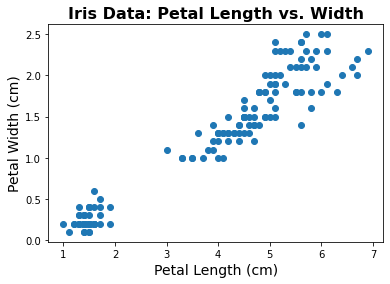

In [8]:
# Let's start looking at some data - plotting petal length vs. petal width
plt.scatter(iris.data[:, pl_ind], iris.data[:, pw_ind])

# Add title and labels
plt.title('Iris Data: Petal Length vs. Width', fontsize=16, fontweight='bold')
plt.xlabel('Petal Length (cm)', fontsize=14);
plt.ylabel('Petal Width (cm)', fontsize=14);

Just from plotting the data, we can see that there seems to be some kind of structure in the data. 

In this case, we do know that there are different species in our dataset, which will be useful information for comparing to our clustering analysis. 

Note that we are not going to use these labels in the clustering analysis itself. Clustering, as we will apply it here, is an unsupervised method, meaning we are not going to use any labels to try and learn the structure of the data. 

To see the structure that is present in the data, let's replot the data, color coding by species.

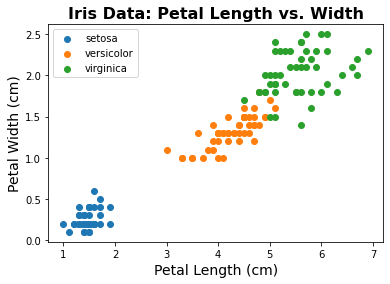

In [9]:
# Plot the data color coded by species
for ind in range(n_labels):
    plt.scatter(iris.data[:, pl_ind][iris.target==ind],
                iris.data[:, pw_ind][iris.target==ind],
                label=iris.target_names[ind])

# Add title, labels and legend
plt.title('Iris Data: Petal Length vs. Width', fontsize=16, fontweight='bold')
plt.xlabel('Petal Length (cm)', fontsize=14);
plt.ylabel('Petal Width (cm)', fontsize=14);
plt.legend(scatterpoints=1, loc='upper left');

# Note that the data, colored by label, can also be plotted like this:
#   plt.scatter(iris.data[:, pl_ind], iris.data[:, pw_ind], c=iris.target)
# It is, however, more difficult to add labelled legend when plotted this way

In this data, we know we have 3 different 'groups' of data, which are the different species. 

As we can see in the plots above, these different species seem to be fairly distinct in terms of their feature values.

The question then is whether we can learn a clustering approach, based on the feature data and without using the labels, that can learn a meaningful grouping of this data. 

If this approach works, then we might be able to try to use it on other data, for which we have feature data, but might not be sure about the groupings present in the data.

## Apply K-Means Clustering

Clustering is the process of trying to learn groups algorithmically. 

For this example, we are going to use the K-means clustering algorithm. 

K-means attempts to group the data into `k` clusters, and does so by labeling each data point to be in the cluster with the nearest mean. To learn the center means, after a random initialization, an iterative procedure assigns each point to a cluster, then updates the cluster centers, and repeats, until a final solution is reached. 

<div class="alert alert-success">
K-means is a clustering algorithm that attempts to learn k clusters by grouping datapoints to the nearest cluster center mean. 
</div>

<div class="alert alert-info">
For more information on K-means, see the article on 
<a href=https://en.wikipedia.org/wiki/K-means_clustering class="alert-link">wikipedia</a>
or on the sklearn
<a href=https://scikit-learn.org/stable/modules/clustering.html#k-means class="alert-link">user guide</a>. 
</div>

In [10]:
# Pull out the data of interest - Petal Length & Petal Width
d1 = np.array(iris.data[:, pl_ind])
d2 = np.array(iris.data[:, pw_ind])

### Whitening Data

In this example, we are using two features (or two dimensions) of data. 

One thing to keep in mind for clustering analyses, is that if different dimensions use different units (or have very different variances), then these differences can greatly impact the clustering. 

This is because K-means is isotropic, which means that it treats differences in each direction as equally important. Because of this, if the units or variance of different features are very different, this is equivalent to weighting certain features / dimensions as more or less important.

To correct for this it is common, and sometimes necessary to 'whiten' the data. 'Whitening' data means normalizing each dimension by it's respective standard deviation. By transforming the data to be on the same scale (have the same variance), we can ensure that the clustering algorithm treats each dimension with the same importance. 

In [11]:
# Check out the whiten function
whiten?

Signature: whiten(obs, check_finite=True)
Docstring:
Normalize a group of observations on a per feature basis.

Before running k-means, it is beneficial to rescale each feature
dimension of the observation set by its standard deviation (i.e. "whiten"
it - as in "white noise" where each frequency has equal power).
Each feature is divided by its standard deviation across all observations
to give it unit variance.

Parameters
----------
obs : ndarray
    Each row of the array is an observation.  The
    columns are the features seen during each observation.

    >>> #         f0    f1    f2
    >>> obs = [[  1.,   1.,   1.],  #o0
    ...        [  2.,   2.,   2.],  #o1
    ...        [  3.,   3.,   3.],  #o2
    ...        [  4.,   4.,   4.]]  #o3

check_finite : bool, optional
    Whether to check that the input matrices contain only finite numbers.
    Disabling may give a performance gain, but may result in problems
    (crashes, non-termination) if the inputs do contain infinities or 

In [12]:
# Whiten Data
d1w = whiten(d1)
d2w = whiten(d2)

In [13]:
# Combine data into an array to use with sklearn
data = np.vstack([d1w, d2w]).T

In [14]:
# Initialize K-means object, and set it to fit 3 clusters
km = KMeans(n_clusters=3, n_init=20,max_iter=3000)

# Fit the data with K-means
km.fit(data);
labels = km.fit_predict(data)

In [21]:
len(labels)

150

In [15]:
km.cluster_centers_

array([[0.83096318, 0.32381517],
       [2.4418233 , 1.74412644],
       [3.1639501 , 2.70668679]])

### Results from KMeans

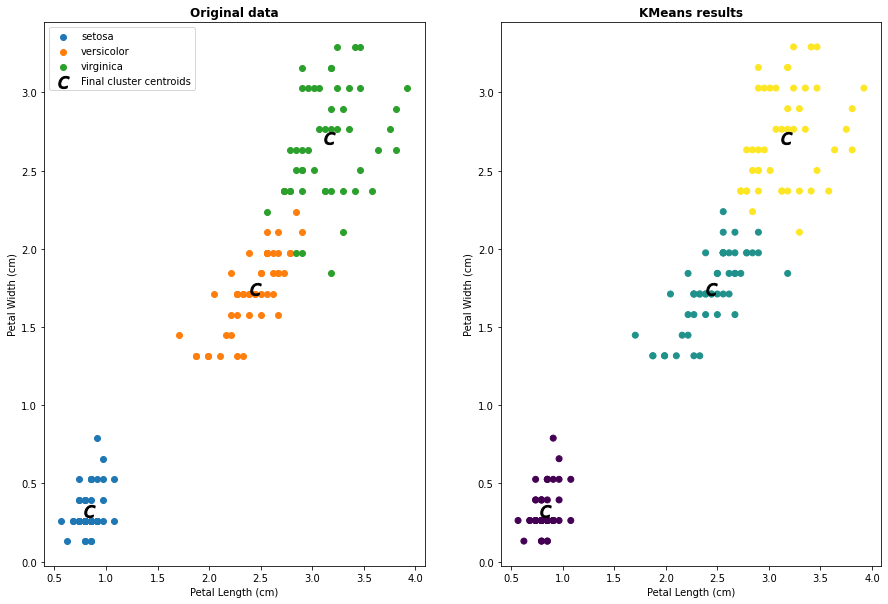

In [23]:
# Getting the Centroids
centroids = km.cluster_centers_
u_labels = np.unique(labels)


# Let's check out the clusters that KMeans found and compare to original data

fig, axs = plt.subplots(1,2, figsize=(15, 10))

for ind in range(n_labels):
    axs[0].scatter(d1w[iris.target==ind],
                d2w[iris.target==ind],
                label=iris.target_names[ind])
axs[0].scatter(centroids[:,0] , centroids[:,1] , marker = '$c$', s = 150, color = 'k', label='Final cluster centroids')
axs[0].set_title('Original data', fontweight='bold')
axs[0].set_xlabel('Petal Length (cm)');
axs[0].set_ylabel('Petal Width (cm)');
axs[0].legend(scatterpoints=1, loc='upper left');

axs[1].scatter(d1w, d2w, c=km.labels_, cmap='viridis');
axs[1].scatter(centroids[:,0] , centroids[:,1] , marker = '$c$', s = 150, color = 'k', label='Final cluster centroids')
axs[1].set_title('KMeans results', fontweight='bold')
axs[1].set_xlabel('Petal Length (cm)', );
axs[1].set_ylabel('Petal Width (cm)', );

In the plot above, each data point is labeled with it's cluster assignment, that we learned from the data. 

In this case, since we do already know the species label of the data, we can see that it seems like this clustering analysis is doing pretty well! There are some discrepancies, but overall a K-means clustering approach is able to reconstruct a grouping of the datapoints, using only information from a couple of the features. 

But how does the KMeans algorithm actually work?

<br>
<img src="img/KMeans_iter.png">
<br>

We start with a random "position" of n clusters (here n=4). In each **E-Step** each object is assigned to the centroid such that it is assigned to the most likely cluster, in the **M-Step** the model (=centroids) are recomputed (= least squares optimization). This process is repeated until best fit found.

## Exercises

<div class="alert alert-danger">
<ul>
    Task 5.1: What are the default options for the sklearn KMeans function (number of clusters and maximal number of iterations). <b>No Code needed for this exercise</b> (1 point).
</ul>
</div>

<div class="alert alert-danger">
<ul>
    Task 5.2: Write a function that performs a KMeans classification between data vectors. It should take the vectors as inputs (data1, data2) and the number of cluster (n_clusters) as inputs. It should return the assigned labels and the mean error per cluster centroid. (1 point).
</ul>
</div>

## Other Clustering Approaches

Clustering is a general task, and there are many different algorithms that can be used to attempt to solve it. 

For example, below are printed some of the different clustering algorithms and approaches that are available in sklearn.

In [17]:
print('Clustering approaches in sklearn:')
for name in dir(cluster):
    if name[0].isupper():
        print('  ', name)

Clustering approaches in sklearn:
   AffinityPropagation
   AgglomerativeClustering
   Birch
   BisectingKMeans
   DBSCAN
   FeatureAgglomeration
   KMeans
   MeanShift
   MiniBatchKMeans
   OPTICS
   SpectralBiclustering
   SpectralClustering
   SpectralCoclustering


Estimated number of clusters: 2
Estimated number of noise points: 11


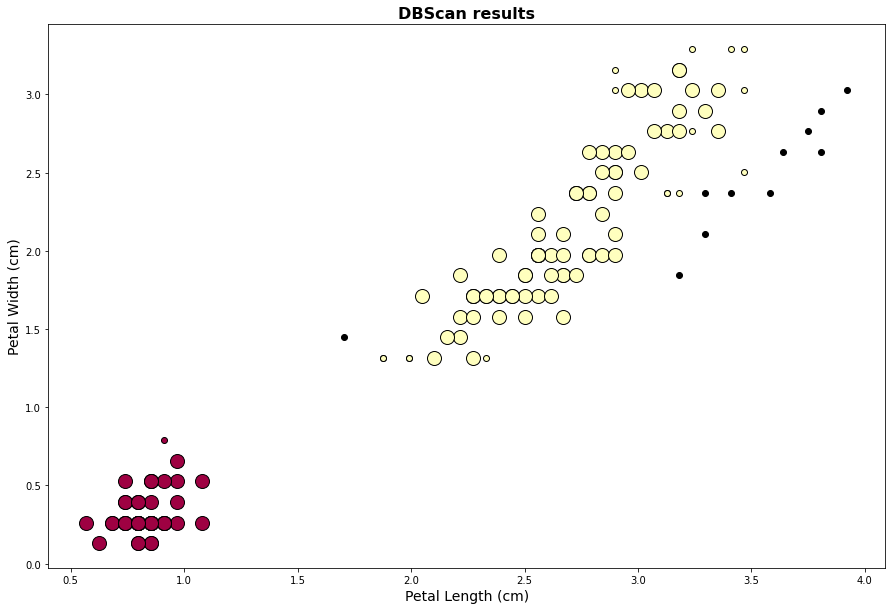

In [18]:
## Example Code DBScan for Iris data

import numpy as np
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(data)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
        
    )

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
        
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.title('DBScan results', fontsize=16, fontweight='bold')
plt.xlabel('Petal Length (cm)', fontsize=14);
plt.ylabel('Petal Width (cm)', fontsize=14);
fig = plt.gcf()
fig.set_size_inches(15,10)